# Regressão Bagging and Bossting

In [28]:
#importando as bibliotecas necessarias para realizar a regressão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_regression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [34]:
#lendo a base de dados
df = pd.read_csv(r'data\diamonds.csv')

In [30]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [35]:
#jogando fora as colunas x,y e z pelo fato de serem muito coorelacionadas com o carat, e a primeira coluna que é o index
df = df.drop(['x','y','z', 'Unnamed: 0'], axis=1)

In [36]:
#using ordinal encoding to encode the categorical variables
df['cut'] = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good','Premium','Ideal']]).fit_transform(df[['cut']])
df['color'] = OrdinalEncoder(categories=[['J', 'I', 'H', 'G', 'F', 'E', 'D']]).fit_transform(df[['color']])
df['clarity'] = OrdinalEncoder(categories=[['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']]).fit_transform(df[['clarity']])

In [37]:
#using standard scaler to scale all the columns
df['carat'] = StandardScaler().fit_transform(df[['carat']])
df['cut'] = StandardScaler().fit_transform(df[['cut']])
df['color'] = StandardScaler().fit_transform(df[['color']])
df['clarity'] = StandardScaler().fit_transform(df[['clarity']])
df['depth'] = StandardScaler().fit_transform(df[['depth']])
df['table'] = StandardScaler().fit_transform(df[['table']])
#df['price'] = StandardScaler().fit_transform(df[['price']])

In [38]:
# Separando variável dependente (price) e independentes
X = df.drop('price', axis=1)
y = df['price']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando o Pipeline com pré-processamento e modelo
pipeline = Pipeline(steps=[
    ('regressor', BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42), random_state=42))
])

# Treinando o modelo com o Pipeline
pipeline.fit(X_train, y_train)

c:\Users\Gabriel Makhoul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('regressor',
                 BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                                  random_state=42))])

In [39]:
# Define the grid of hyperparameters
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_samples': [0.5, 0.75, 1.0],
    'regressor__max_features': [0.5, 0.75, 1.0],
    'regressor__base_estimator__max_depth': [5, 10, None]
}

In [40]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [41]:
# Fit the model
grid_search.fit(X_train, y_train)

c:\Users\Gabriel Makhoul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('regressor',
                                        BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                                                         random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__base_estimator__max_depth': [5, 10, None],
                         'regressor__max_features': [0.5, 0.75, 1.0],
                         'regressor__max_samples': [0.5, 0.75, 1.0],
                         'regressor__n_estimators': [10, 50, 100]},
             scoring='neg_mean_squared_error')

In [42]:
# Best parameters and performance
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Negative MSE: {grid_search.best_score_}")

Best Parameters: {'regressor__base_estimator__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_samples': 0.5, 'regressor__n_estimators': 100}
Best Negative MSE: -302082.42534794984


In [43]:
# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

In [44]:
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

Test MSE: 294405.62
Test R²: 0.98
Test RMSE: 542.59


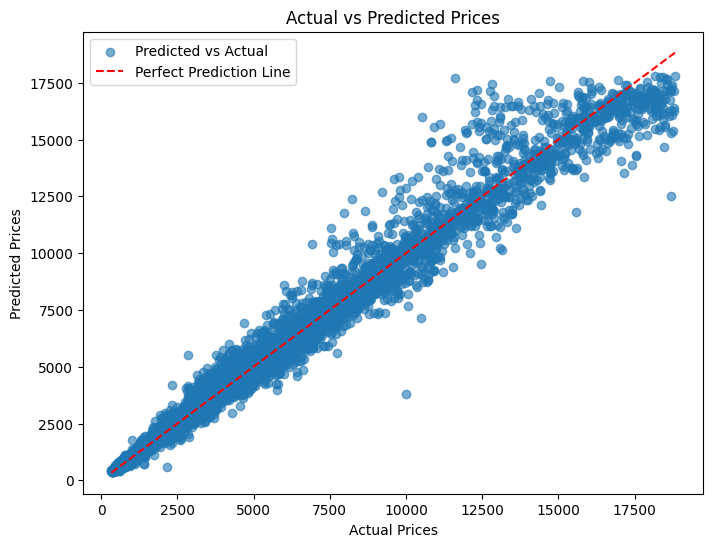

In [45]:
# Evaluate and print metrics
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test RMSE: {np.sqrt(test_mse):.2f}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, label="Predicted vs Actual")

# Adding a line to show perfect prediction
min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction Line")

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()

In [47]:
# Separando variável dependente (price) e independentes
X = df.drop('price', axis=1)
y = df['price']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Treinando o modelo com o Pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('regressor', GradientBoostingRegressor(random_state=42))])

In [48]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.8, 1.0],
    'regressor__min_samples_split': [2, 5, 10]
}

In [49]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [50]:
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 300],
                         'regressor__subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [51]:
# Best parameters and performance
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Negative MSE: {grid_search.best_score_}")

Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
Best Negative MSE: -282939.1770667046


In [52]:
# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

In [53]:
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

Test MSE: 280468.76
Test R²: 0.98
Test RMSE: 529.59


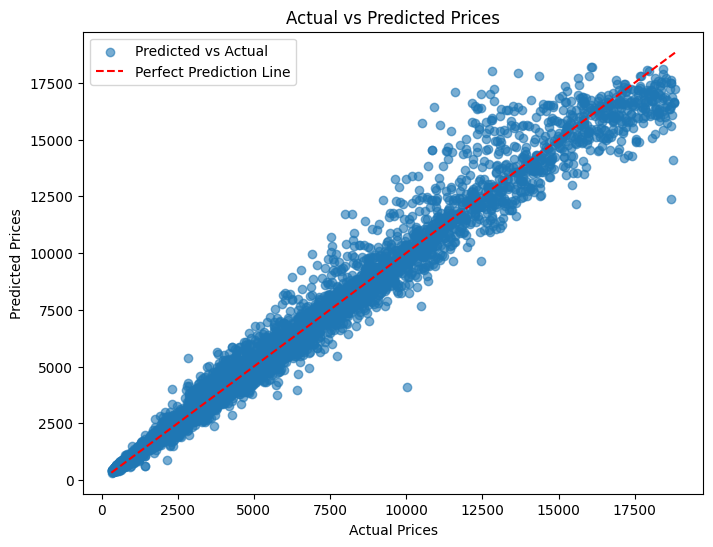

In [55]:
# Evaluate and print metrics
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test RMSE: {np.sqrt(test_mse):.2f}")

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, label="Predicted vs Actual")

# Adding a line to show perfect prediction
min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction Line")

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()